# **Image segmentation**
There are various levels of granularity in which the computers can gain an understanding of images. For each of these levels there is a problem defined in the Computer Vision domain. Starting from a coarse grained down to a more fine grained understanding, let’s describe these problems below:

* Image classification

![](https://github.com/Al-Afandi/neural_network_course/blob/main/classification.png?raw=1)


The most fundamental building block in Computer Vision is the Image classification problem where given an image, we expect the computer to output a discrete label, which is the main object in the image. In image classification we assume that there is only one (and not multiple) object in the image.

* Classification with Localization

![](https://github.com/Al-Afandi/neural_network_course/blob/main/localization.jpeg?raw=1)

In localization along with the discrete label, we also expect the compute to localize where exactly the object is present in the image. This localization is typically implemented using a bounding box which can be identified by some numerical parameters with respect to the image boundary. Even in this case, the assumption is to have only one object per image.

* Object Detection

![](https://github.com/Al-Afandi/neural_network_course/blob/main/object_detection.jpeg?raw=1)

Object Detection extends localization to the next level where now the image is not constrained to have only one object, but can contain multiple objects. The task is to classify and localize all the objects in the image. Here again the localization is done using the concept of bounding box.

* Semantic Segmentation

![](https://github.com/Al-Afandi/neural_network_course/blob/main/segmentation.png?raw=1)

The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction.

Note that unlike the previous tasks, the expected output in semantic segmentation are not just labels and bounding box parameters. The output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. Thus it is a pixel level image classification.

* Instance segmentation


![](https://github.com/Al-Afandi/neural_network_course/blob/main/instance_segmentation.jpeg?raw=1)

Instance segmentation is one step ahead of semantic segmentation wherein along with pixel level classification, we expect the computer to classify each instance of a class separately. For example in the image above there are 3 people, technically 3 instances of the class “Person”. All the 3 are classified separately (in a different color). But semantic segmentation does not differentiate between the instances of a particular class.

If you are still confused between the differences of object detection, semantic segmentation and instance segmentation, below image will help to clarify the point:

![](https://github.com/Al-Afandi/neural_network_course/blob/main/segmentation_approaches.png?raw=1)

In this post we will learn to solve the Semantic Segmentation problem using Fully Convolutional Network (FCN) called UNET.

We will use Clevr dataset, a synthesized dataset which we will use for simplicity. The dataset contains 25200 colored images (of size $320 \times 240$) of simple objects along with their semantic masks (containing three different object types: cubes, spheres and cylinders), instance masks, amodal masks, pairwise occlusion masks and three-dimensional coordinates and sizes for each object.

This results a simple dataset for various tasks, ranging from instance segmentation to three-dimensional reconstruction. The dataset contains objects of simple shapes, but also contains shadows, reflections and different illuminations, which make it relevant for the evaluation of segmentation algorithms.

Let us import the required libraries and load the dataset which we will download from a server.

In [4]:
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim

import os
import random

In [5]:
if not os.path.exists("clevr_types_images.zip"):
    !wget http://users.itk.ppke.hu/~horan/ANN/08_segmentation/clevr_types_images.zip
    !unzip clevr_types_images.zip

We will select 1500 images for training. We will read the first 1500 images and put them in a big numpy array. We will choose 200 images for testing. We will save the dataset for an easy future access.

In [1]:
TrainNum = 1500
ImgShape = [572, 572, 3]
trainimages = []
trainmasks = []

for num in range(TrainNum):
    trainmasks.append("images/all_objects"+str(num).zfill(6)+".png")
    trainimages.append("images/CLEVR_view_"+str(num).zfill(6)+".png")

TestNum = 200
testimages = []
testmasks = []

for num in range(TrainNum, TrainNum+TestNum):
    testmasks.append("images/all_objects"+str(num).zfill(6)+".png")
    testimages.append("images/CLEVR_view_"+str(num).zfill(6)+".png")


We will build another auxiliary function which will help us to train the model by returning a batch of samples randomly. Now we can easily access the training and testing samples with thier ground truth.

In [2]:
def get_next_batch(img, mask, batch_length):
    used_in_batch = random.sample(range(len(img)), batch_length)
    images = np.zeros(([batch_length] + ImgShape))
    Masks = np.zeros(([batch_length] + ImgShape))
    for ind, i in enumerate(used_in_batch):
        images[ind] = cv2.resize(cv2.imread(
            img[i]), (ImgShape[1], ImgShape[0]))
        Masks[ind] = cv2.resize(cv2.imread(
            mask[i]), (ImgShape[1], ImgShape[0]))
    return images, Masks


Let us plot one random sample with it's ground truth.

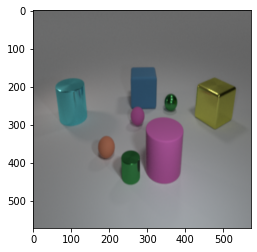

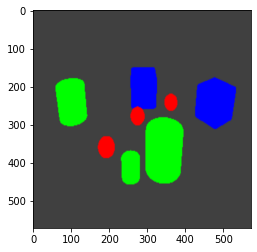

In [6]:
img, mask = get_next_batch(trainimages, trainmasks, 1)

plt.imshow(img[0, :, :, :].astype(np.uint8))
plt.figure()
plt.imshow(mask[0, :, :, :].astype(np.uint8))
plt.show()


# **UNet**

When learning image segmentation UNet serves as one of the basic models for the segmentation. UNet is one of the most used models for image segmentation. You can see people are making a lot of changes in the Original UNet architecture like using Resnet etc. but let’s implement the Original UNet Architecture.

**Architecture of the Unet.**

![](https://github.com/Al-Afandi/neural_network_course/blob/main/unet.jpeg?raw=1)

The architecture of the Unet can be divided into two parts: Left (Contracting path) & Right (Expansion path).

The Encoder is like any standard CNN - such as ResNet, that extracts a meaningful feature map from an input image. As is standard practice for a CNN, the Encoder, doubles the number of channels at every step and halves the spatial dimension.

Next, the Decoder actually upsamples the feature maps, where at every step, it doubles the spatial dimension and halves the number of channels (opposite to that of what an Encoder does).

The Encoder part is just a simple convolution network. In the left part Two 3x3 Convolution layers followed by a Relu activation function are stacked together (Sequentially) and a 2x2 maxpool layer is applied after that(red arrow in image) First vertical bar in the left side in the image is not a layer but represents the input.(input image tile)

The Decoder part is where interesting things happen. Right part also uses Two 3x3 Convolution layers stacked together (Sequentially) like left side but there is no maxpool layer used instead a 2x2 Transpose convolution layer is used (green arrow in image ). we apply an upsampling operation $ConvTranspose2d$ which doubles the height and width of the image and reduces the number of channels by half. During the expansion path, we will take the image (copy ) from the left side and combine it with the image on the right (grey arrow in the image). Remember a sequential 3x3 convolution layers are also used in the right side so the input for that will be combination of the image from right and its previous layer (half white and blue box in the right side of the image is the combination).

The output layer on the right side an extra convolution layer is applied (output segmentation map ).

As we have seen in the architecture a 3x3 double convolution layer followed by the Relu activation function is used on both right and left side. Thus, let us build a function which can do just that.



In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        # Implement a nn.Sequentel
        # conv2d -> ReLU -> conv2d -> ReLU
        # conv kernel size = 3, no padding
        # call it "double_conv"

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            # inplace: not creating new variable, but overwriting
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


For a better illusteration let us look at the figure below where we clearly see that encoder are down sampling the image 4 times while the decoder is up sampling the image 4 times. 

![](https://github.com/Al-Afandi/neural_network_course/blob/main/Unet_simple.png?raw=1)

let us build the down sampling function first as this one should be familiar from last two practices.


In [6]:
# Implement a class called "Down"
# It will be a similar module as DoubleConv
# It has two parameters: in_channels, out_channels
# It contains a nn.Sequentel:
# maxpool2d -> DoubleConv
# maxpool kernel_size=2, stride=2

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


Creating the up sampling function will be our next task which we will create relying on Transpose Convolution Operation, $ConvTranspose2d$. It is very similar to the convolution operation, only that the convolution matrix is transposed. It is used to upsample the input feature map to a desired output feature map using some learnable parameters. 

Consider a 2x2 encoded feature map which needs to be upsampled to a 3x3 feature map. 

![](https://github.com/Al-Afandi/neural_network_course/blob/main/input.png?raw=1)

We take a kernel of size 2x2 with unit stride and zero padding.

![](https://github.com/Al-Afandi/neural_network_course/blob/main/kernal.png?raw=1)

Now we take the upper left element of the input feature map and multiply it with every element of the kernel.Similarly, we do it for all the remaining elements of the input feature map. Some of the elements of the resulting upsampled feature maps will over-lap. To solve this issue, we simply add the elements of the over-lapping positions. 

![](https://github.com/Al-Afandi/neural_network_course/blob/main/transposed.png?raw=1)
 
The resulting output will be the final upsampled feature map having the required spatial dimensions of 3x3.

Transposed convolution is also known as Deconvolution which is not appropriate as deconvolution implies removing the effect of convolution which we are not aiming to achieve.

It is also known as upsampled convolution which is intuitive to the task it is used to perform, i.e upsample the input feature map.

Last thing I have to mention before going on with the task is that we have to concatenate the feature maps from the down sampled side of the network. As you can notce from the UNet figure before the size of the down sampled feature map is bigger, so we will calculate the size difference and then center crop the feature maps of the down sampled side.   

In [7]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()

        self.up = nn.ConvTranspose2d(
            in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_up, x_down):
        x_up = self.up(x_up)
        up_tensor_size = x_up.size()[2]
        down_tensor_size = x_down.size()[2]

        # calculate dif between tensor sizes
        diff = down_tensor_size - up_tensor_size
        half_diff = diff // 2
        other_half = diff - half_diff

        # Resize x_down using down_tensor_size, half_diff and other_half

        x_down_resized = x_down[:, :, half_diff:down_tensor_size-other_half]

        x = torch.cat([x_down_resized, x_up], dim=1)
        return self.conv(x)


Now that we have he down sampling and up sampling functions, we can easily build our UNet model.

In [8]:
class Unet(nn.Module):
    def __init__(self, i_ch_n, o_ch_n):
        super(Unet, self).__init__()

        # parameters:
        self.input_channel_num = i_ch_n
        self.output_channel_num = o_ch_n
        #self.bilinear = bilinear

        # downscaleing layers
        self.inc = DoubleConv(self.input_channel_num, 64)

        # Downscaling layers
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # Upscaling layers
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        self.outconv = nn.Conv2d(64, self.output_channel_num, kernel_size=1)

    def forward(self, x):

        # Implement the forward pass:
        # inc conv -> down part -> up part -> outconv

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x5 = self.down4(x4)

        x6 = self.up1(x5, x4)
        x7 = self.up2(x6, x3)
        x8 = self.up3(x7, x2)
        x9 = self.up4(x8, x1)

        logits = self.outconv(x9)

        print("x1: " + str(x1.size()))

        print("x2: " + str(x2.size()))
        print("x9: " + str(x9.size()))

        print("x3: " + str(x3.size()))
        print("x8: " + str(x8.size()))

        print("x4: " + str(x4.size()))
        print("x7: " + str(x7.size()))

        print("x5: " + str(x5.size()))
        print("x6: " + str(x6.size()))

        return logits


Let us create an instance of our model where the number of channels in the input is 3 

In [9]:
model = Unet(3, 3)
print(model)


Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(256, 256, ker

Let us see how many parameters does our model have?

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 31,031,875 trainable parameters


We will define no the parameters which we will for training

In [11]:
batch_length = 4
# input image shape
input_shape = [240, 320, 3]
# `label` shape (here we usually call it ground truth, because there is no definite answer)
ground_truth_shape = [240, 320, 3]
leaning_rate = 1e-3
num_iteration = 8000


Next we define the criterion (loss function) and place the model and criterion on our device.

In [12]:
optimizer = optim.Adam(model.parameters(), lr=leaning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


Now let us start the trainig as we usually do. 

In [18]:
# transform for the fround truth mask:
test_input = torch.randn((1, ImgShape[2], ImgShape[0], ImgShape[1]))

if torch.cuda.is_available():
    test_output = model(test_input.to(device))
else: 
    test_output = model()
center_crop_transofrm = transforms.CenterCrop((test_output.shape[2:]))

step = 0
while step < num_iteration:
    step += 1

    img_batch, mask_batch = get_next_batch(
        trainimages, trainmasks, batch_length)

    img_batch = torch.from_numpy(img_batch).permute(
        (0, 3, 1, 2)).type(torch.FloatTensor).to(device)
    mask_batch = torch.from_numpy(mask_batch).permute(
        (0, 3, 1, 2)).type(torch.FloatTensor).to(device)

    optimizer.zero_grad()

    output_mask = model(img_batch)
    mask_batch = center_crop_transofrm(mask_batch)

    loss = criterion(output_mask, mask_batch)

    loss.backward()

    optimizer.step()

    if (step % 100) == 0:
        # train accuracy
        print('Iteration: %d, loss: %.5f' % (step, loss), flush=True)

    if (step % 1000) == 0:
        assert len(test_img) == len(test_mask)
        img_batch, mask_batch = get_next_batch(
            testimages, testmasks, batch_length)

        img_batch = torch.from_numpy(img_batch).type(
            torch.FloatTensor).permute((0, 3, 1, 2)).cuda()
        mask_batch = torch.from_numpy(mask_batch).type(
            torch.FloatTensor).permute((0, 3, 1, 2)).cuda()

        output_mask = model(img_batch)
        loss = criterion(output_mask, mask_batch)

        print('Loss on test set: %.5f at step %d\n' % (loss, step), flush=True)
        # display images
        plt.figure()
        plt.imshow(img_batch[0, :, :, :].astype(np.uint8))
        plt.figure()
        plt.imshow(output_mask[0, :, :, :].astype(np.uint8))
        plt.figure()
        plt.imshow(mask_batch[0, :, :, :].astype(np.uint8))
        plt.show()


TypeError: forward() missing 1 required positional argument: 'x'